In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../scripts') 

from qutip_tools import *


In [2]:
# define basic figure sizes
bwidth=7.5
bheight=5
base_font = 30

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/for_poster/"


In [3]:
data_route = "../data/sims/L=21/"
J=1

In [4]:
def get_partial_trace(Psi, NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: Quobject from Qutip representing the wavefunction
    # NN: integer with the total size of the lattice

    n = 2 ** (NN - 2)  # QPC sites
    m = 2 ** 2  # Double dot sites
    # get density matrix as a sparse array
    ps = sparse.csr_matrix(Psi.full())
    A = sparse.kron(ps, np.conj(ps.T))
    # convert to normal array for partial trace operation
    Adense = A.toarray()
    # trace out QPC sites and return reduced rho for DD as Quobject
    return Qobj(np.trace(Adense.reshape(n, m, n, m), axis1=0, axis2=2))



def get_file_names_on(param_list, route):
    name_list = os.listdir(route)
    try:
        name_list.remove('.DS_Store')
    except:
        pass
    # gets a list of the hdf5 file names with t dependent data depending on the values in param_list
    for subs in param_list:
        # getting strings with parameters that we want
        name_list = list(filter(lambda x: subs in x, name_list))
    return name_list

In [5]:
data_full_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

print("Number of data points:", len(data_full_df))
print(data_full_df.columns)
data_full_df.head()


Number of data points: 1398
Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi', 'dd_density_hit'],
      dtype='object')


,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi,dd_density_hit
0,21,18.0,400,7,0.5,0.392699,1.0,0.0,0.40,0.765367,...,1.000000,8.992806e-15,10,0.951081,fixed,0.564233,2.107342e-08,0.000000,1.570796,1.000000
1,21,18.0,400,7,0.5,0.981748,1.0,0.4,0.01,1.662939,...,0.999962,2.238491e-04,10,0.802858,fixed,0.012193,2.895775e+00,1.535108,0.035688,0.030646
2,21,18.0,400,7,2.0,0.392699,1.0,0.2,0.50,0.765367,...,0.902862,2.020031e-01,10,0.827560,fixed,0.834754,1.550818e+00,-1.090803,2.661600,0.547722
3,21,18.0,400,7,0.5,0.981748,1.0,0.1,0.05,1.662939,...,0.998104,7.552377e-03,10,0.801953,fixed,0.060610,2.291796e+00,1.488497,0.082299,0.883334
4,21,18.0,400,7,2.0,0.392699,1.0,0.3,0.10,0.765367,...,0.994725,1.833645e-02,10,0.872464,fixed,0.171816,6.310212e-01,1.405248,0.165548,0.243214


In [6]:
data_full_df[data_full_df["time_f_int"]<0].describe()
data_full_df = data_full_df[data_full_df["vg"]>0]

# here we can choose wether we want just the "fixed" by k0 initial conditions
# or the fully localized "second"
data_df = data_full_df[data_full_df["ddot0"]=="fixed"]


In [7]:
print(data_df.columns)

print("omega")
print(data_df['Omega'].unique())
print("t")
print(data_df['t'].unique())
print(data_df['k0'].unique())

Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi', 'dd_density_hit'],
      dtype='object')
omega
[0.4  0.01 0.5  0.05 0.1  0.   0.7  0.3  0.2 ]
t
[0.   0.4  0.2  0.1  0.3  0.01 0.8  0.5  0.7  0.6  0.9  0.05 1.  ]
[0.39269908 0.9817477  1.37444679 1.17809725 1.57079633 0.78539816
 0.52359878]


In [8]:
# defining our parameters
L_=21
Om_ = 0.3
Deltax_ = 2.0



"""Z = 10.0 * (Z2 - Z1)
clev = np.arange(Z.min(),Z.max(),.001) #Adjust the .001 to get finer gradient
CS = plt.contourf(X, Y, Z, clev, cmap=plt.cm.coolwarm)
plt.show()"""



'Z = 10.0 * (Z2 - Z1)\nclev = np.arange(Z.min(),Z.max(),.001) #Adjust the .001 to get finer gradient\nCS = plt.contourf(X, Y, Z, clev, cmap=plt.cm.coolwarm)\nplt.show()'

array([[0.00404514, 0.05504504, 0.10917779, 0.11006222, 0.09998552,
        0.09336373, 0.09427465, 0.09424087, 0.07694223, 0.06642391,
        0.07234839, 0.07134782],
       [0.00664189, 0.08206625, 0.13665382, 0.11916101, 0.11843612,
        0.08791551, 0.08656568, 0.09089121, 0.07125545, 0.06449279,
        0.06415612, 0.06532193],
       [0.00549015, 0.07178904, 0.13831183, 0.15723225, 0.14167644,
        0.10900137, 0.09681139, 0.08664783, 0.08649041, 0.07534465,
        0.06333767, 0.0515709 ],
       [0.00423766, 0.05930778, 0.12953989, 0.15564882, 0.13320417,
        0.09759715, 0.08815409, 0.09561541, 0.08541453, 0.0654066 ,
        0.05543625, 0.04809435],
       [0.00359913, 0.05180789, 0.11979389, 0.15296179, 0.12408295,
        0.09123774, 0.09955367, 0.10783199, 0.08592601, 0.06495161,
        0.05960452, 0.05340272],
       [0.00322144, 0.04708561, 0.11247434, 0.15069276, 0.11510567,
        0.08674949, 0.10785894, 0.1139202 , 0.08626002, 0.06879664,
        0.0644861 ,

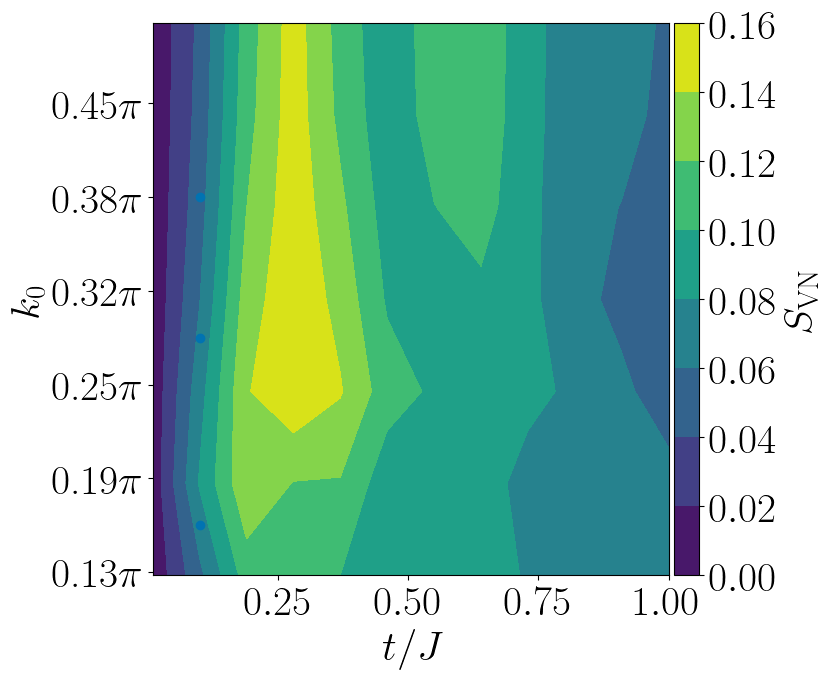

In [130]:
cond = (data_df["Omega"] == 0.3) & (data_df["x_spread"]==2.0) & (data_df["t"]>0)

S_df = data_df[cond].pivot(index="k0", columns="t", values="max_VN_entropy")

fig, ax = plt.subplots(1,1,figsize=(bwidth+1.5,bwidth))


vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(S_df.values, extent=[min(t_array), max(t_array),min(vg_array), max(vg_array)], 
                cmap="viridis")

plt.scatter([0.1,0.1,0.1], [0.5,0.9,1.2])

ax.set_ylabel(r"$k_0$")
ax.set_xlabel(r"$t/J$")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{\rm{VN}}$', rotation=90)

#write x axis in units of pi
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.2f}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.tight_layout()

plt.savefig(fig_route+"entropy_phase_diagram_L_={}_bw={}om={}.pdf".format(L_, Deltax_, Om_), transparent=True)

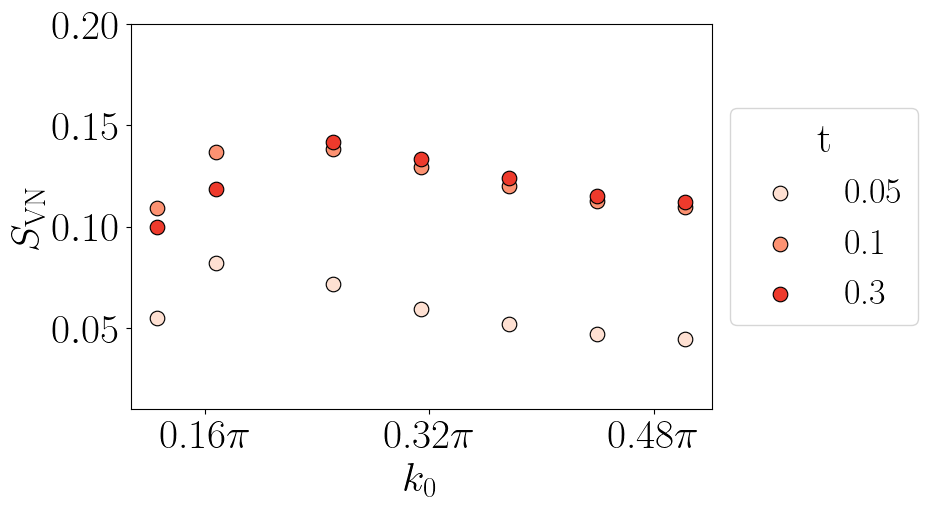

<Figure size 640x480 with 0 Axes>

In [129]:
fig, ax = plt.subplots(1,1,figsize=(bwidth,bheight))



plt.figure()

red_p = sns.color_palette(palette='Reds', n_colors=7)
# plot by colors
t_ = 0.05
c = red_p[0]
cond = (data_df['t']==t_) & \
        (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)
sns.scatterplot(data = data_df[cond], x="k0" ,y="max_VN_entropy",color=c ,
                label=t_,edgecolor='black' ,s=110,ax=ax)

t_ = 0.1
c = red_p[2]
cond = (data_df['t']==t_) & \
        (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)
sns.scatterplot(data = data_df[cond], x="k0" ,y="max_VN_entropy",color=c ,
                label=t_,edgecolor='black' ,s=110,ax=ax)

t_ = 0.3
c = red_p[4]
cond = (data_df['t']==t_) & \
        (data_df["x_spread"] == Deltax_) & (data_df["Omega"] == Om_)
sns.scatterplot(data = data_df[cond], x="k0" ,y="max_VN_entropy",color=c ,
                label=t_,edgecolor='black' ,s=110,ax=ax)


ax.set_xlabel(r"$k_0$")
ax.set_ylabel(r"$S_{\rm{VN}}$")
ax.set_ylim(0.01,0.2)

ax.legend(title="t", loc='center left', bbox_to_anchor=(1, 0.5))


#write x axis in units of pi
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.2f}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

